In [2]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 22.2 MB 8.7 MB/s             
     |████████████████████████████████| 306 kB 11.1 MB/s            
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=6b99b422b1624c6a0ed3e26d71227345bad53d194bda0d3370fc5f49b1f5bdc8
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets

In [4]:
iris = datasets.load_iris()

x_vals = np.array([x[0:3] for x in iris.data])
y_vals = np.array([x[3] for x in iris.data])

In [6]:
seed = 3
tf.random.set_seed(seed)
np.random.seed(seed)

In [8]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

In [9]:
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [10]:
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

In [11]:
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [12]:
batch_size = 50
x_data = tf.keras.Input(dtype=tf.float32, shape=(3, ))

In [13]:
hidden_layer_nodes = 5
a1 = tf.Variable(tf.random.normal(shape=[3, hidden_layer_nodes], seed=seed))
b1 = tf.Variable(tf.random.normal(shape=[hidden_layer_nodes], seed=seed))
a2 = tf.Variable(tf.random.normal(shape=[hidden_layer_nodes, 1], seed=seed))
b2 = tf.Variable(tf.random.normal(shape=[1], seed=seed))

In [14]:
hidden_output = tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, a1), b1)))
final_output = tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, a2), b2)))

hidden_layer = hidden_output(x_data)
output = final_output(hidden_layer)

model = tf.keras.Model(inputs=x_data, outputs=output, name="1layer_nn")

optimizer = tf.keras.optimizers.SGD(0.005)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(3, 5) dtype=float32>
  <tf.Variable 'Variable:0' shape=(5,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(5, 1) dtype=float32>
  <tf.Variable 'Variable:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [15]:
loss_vec = []
test_loss = []

for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])

    with tf.GradientTape(persistent=True) as tape:
        output = model(rand_x)
        loss = tf.reduce_mean(tf.square(rand_y - output))
        loss_vec.append(np.sqrt(loss))

    gradients_a1 = tape.gradient(loss, a1)
    gradients_b1 = tape.gradient(loss, b1)
    gradients_a2 = tape.gradient(loss, a2)
    gradients_b2 = tape.gradient(loss, b2)

    optimizer.apply_gradients(zip([gradients_a1, gradients_b1, gradients_a2, gradients_b2], [a1, b1, a2, b2]))

    output_test = model(x_vals_test)

    loss_test = tf.reduce_mean(tf.square(np.transpose([y_vals_test]) - output_test))
    test_loss.append(np.sqrt(loss_test))

    if (i+1)%50==0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(np.mean(loss)))

Generation: 50. Loss = 0.46484688
Generation: 100. Loss = 0.1673796
Generation: 150. Loss = 0.17597003
Generation: 200. Loss = 0.16173406
Generation: 250. Loss = 0.07975028
Generation: 300. Loss = 0.1328429
Generation: 350. Loss = 0.1194209
Generation: 400. Loss = 0.16155118
Generation: 450. Loss = 0.16793051
Generation: 500. Loss = 0.08968163


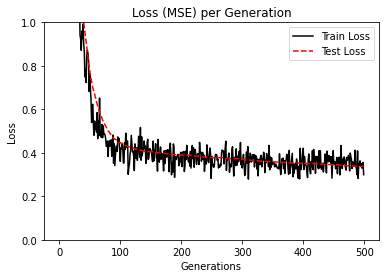

In [16]:
%matplotlib inline
# plot loss (MSE) over time
plt.ylim([0, 1.0])
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generations')
plt.ylabel('Loss')
plt.show()